# Lab 1: Problem 1 (MDP algorithms: tabular Q-learning)

*OpenAI gym FrozenLake environment*

Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    
FrozenLake-v1 defines "solving" as getting average reward of 0.78 over 100 consecutive trials.

More documentation: https://www.gymlibrary.dev/environments/toy_text/frozen_lake/


In [21]:
%reload_ext autoreload
%autoreload 2

In [22]:
from kret_studies import *
from kret_studies.notebook import *
from kret_studies.complex import *

logger = get_notebook_logger()

/Users/Akseldkw/coding/kretsinger/data/nb_log.log


In [23]:
env_vars = os.environ.copy()
wand_db_dir = env_vars["OUTPUT_DIR"] + "/wandb"

In [24]:
# wandb set up for logging runs online and moving them to the leaderboard
# create a wandb account when prompted, or simply sign in if you already have an account
# !pip install wandb -qqq
import wandb

wandb.login()

In [25]:
## DO NOT CHANGE THIS CELL
import numpy as np
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import FrozenLakeEnv

env = typing.cast(FrozenLakeEnv, gym.make("FrozenLake-v1", is_slippery=True))
# env.seed(0)

## Cartoon Rendering

![Frozen-Lake](./Frozen-Gym.png)

For proper accounting rewards while you learn, we build a wrapper around env.step() and env.reset(). In an episode, every time you take an action the reward will be appended to the reward of the episode, and when ever the environment is reset (at the end of an epsiode), the episode reward is reset to 0.

In [49]:
from functools import wraps

## DO NOT CHANGE THIS CELL
# wrapper for accounting rewards
rEpisode = 0
rList = []
fixedWindow = 100
movingAverage = 0


def reset_decorate(func):
    @wraps(func)
    def func_wrapper(*args, **kwargs):
        global rList
        global movingAverage
        global rEpisode
        global fixedWindow
        rList.append(rEpisode)
        if len(rList) >= fixedWindow:
            movingAverage = np.mean(rList[len(rList) - fixedWindow : len(rList) - 1])
        rEpisode = 0
        return func(*args, **kwargs)

    return func_wrapper


env.reset = reset_decorate(env.reset)


def step_decorate(func):
    @wraps(func)
    def func_wrapper(*args, **kwargs):
        global rEpisode
        # Call the original step function and unpack the result
        result = func(*args, **kwargs)
        if len(result) == 5:
            s1, r, d, other, info = result
            rEpisode += r
            return (s1, r, d, other, info)
        else:
            raise ValueError("Unexpected number of return values from env.step")

    return func_wrapper


env.step = step_decorate(env.step)


def init():
    global rEpisode, rList, movingAverage
    rEpisode = 0
    rList = []
    movingAverage = 0
    return

Below we illustrate the execution of the Open AI gym enviornment using the policy of chosing random action in every state. Every time an action is taken the enviorment returns a tuple containing next state, reward, and the status (whether terminal state is reached or not).

In [50]:
### RANDOM SAMPLING EXAMPLE
num_episodes = 1000
# number of episodes you want to try
episode_max_length = 100
# you can explicitly end the epsiode before terminal state is reached

env.reset()
# env.render()
# execute in episodes
for i in range(num_episodes):

    # reset the environment at the beginning of an episode
    s = env.reset()
    d = False  # not done

    for t in range(episode_max_length):

        ################ Random action policy ###########################
        # play random action
        a = env.action_space.sample()
        # get new state, reward, done
        s, r, d, _, info = env.step(a)
        #################################################################

        # break if done, reached terminal state
        if d == True:
            break

    # log per-episode reward and moving average over 100 episodes
    # wandb.log(
    #     {
    #         "random reward": rEpisode,
    #         "random reward moving average": movingAverage,
    #         "random episode": i,
    #     }
    # )

Implement tabular Q-learning (*YOU SHOULD ONLY CHANGE THE CELL BELOW*)

In [51]:
"""Action Space
The action shape is `(1,)` in the range `{0, 3}` indicating
which direction to move the player.

- 0: Move left
- 1: Move down
- 2: Move right
- 3: Move up

## Observation Space
The observation is a value representing the player's current position as
`current_row * ncols + current_col` (where both the row and col start at 0).
Therefore, the observation is returned as an integer.

For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15.
The number of possible observations is dependent on the size of the map.

NOTE ^ this was copied from the class docstring

>>> [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
"""

...

Ellipsis

In [ ]:
grid_env = typing.cast(FrozenLakeEnv, env.unwrapped)
env.observation_space = typing.cast(gym.spaces.Discrete, env.observation_space)
env.action_space = typing.cast(gym.spaces.Discrete, env.action_space)
state_shift = {0: -1, 1: 4, 2: 1, 3: -4}


def check_valid_strict(state: int, action: int) -> bool:
    """
    Check if the action is valid for the given state.
    """
    next_state = state + state_shift[action]
    # Check for invalid moves: out of bounds or wrapping around edges
    ncols = grid_env.ncol
    nrows = grid_env.nrow

    # Compute current row and col
    row, col = divmod(state, ncols)

    # For left, can't move if col == 0
    if action == 0 and col == 0:
        return False
    # For right, can't move if col == ncols - 1
    elif action == 2 and col == ncols - 1:
        return False
    # For up, can't move if row == 0
    elif action == 3 and row == 0:
        return False
    # For down, can't move if row == nrows - 1
    elif action == 1 and row == nrows - 1:
        return False
    # Out of bounds
    elif next_state < 0 or next_state >= env.observation_space.n:
        return False
    return True


def check_valid_loose(state: int, action: int) -> bool:
    """
    Check if the action is valid for the given state.
    Loose check: only checks for out of bounds, allows wrapping around edges
    """
    next_state = state + state_shift[action]
    # Check for invalid moves: out of bounds
    if next_state < 0 or next_state >= env.observation_space.n:
        return False
    return True


def inbounds(Q: np.ndarray, state: int) -> bool:
    # next_state = state + state_shift[action]
    if state < 0 or state >= Q.shape[0]:
        return False
    return True


def smart_q_values(Q: np.ndarray, state: int, clever: bool = False):
    """
    Return the Q-value for a given state and action.
    If clever is True, set a negative Q-value for left or up actions that would move the
    agent away from the goal
    """
    state_shift = {0: -1, 1: 4, 2: 1, 3: -4}
    action_to_word = {0: "left", 1: "down", 2: "right", 3: "up"}

    q_values = []
    for action in state_shift.keys():
        if clever and action_to_word[action] in ["left", "up"]:
            """early exit if moving away from goal"""
            q_values.append(-np.inf)  # Discourage moving away from the goal

        # elif not check_valid_loose(state, action):
        #     q_values.append(-np.inf)  # Invalid move
        else:
            next_state = state + state_shift[action]
            max_val = (
                np.max(Q[next_state]) if inbounds(Q, next_state) else np.mean(Q[state])
            )
            q_values.append(max_val)

    return np.array(q_values)


def e_greedy_mask(action_values: np.ndarray, epsilon: float = 0.4) -> np.ndarray:
    """
    Create an epsilon-greedy mask for action selection.
    With probability epsilon, all actions are equally likely.
    With probability (1 - epsilon), only the best action is chosen.
    If any action_values are -np.inf, set their mask to 0 and renormalize so mask sums to 1.
    """
    valid = action_values > -np.inf
    val_count = valid.sum()
    probs = np.zeros_like(action_values, dtype=float)
    if val_count == 0:
        return probs  # all actions invalid

    best_idx = np.argmax(action_values)
    probs[best_idx] = 1 - epsilon
    remaining_prob = epsilon / val_count
    probs[valid & (np.arange(len(action_values)) != best_idx)] = remaining_prob
    probs = probs / probs.sum()

    return probs

In [91]:
"""I'm moving this into its own cell so as to avoid resetting Q and n every time I re-run the training cell."""

# create Q table
Q = np.zeros(
    [env.observation_space.n, env.action_space.n]
)  # Q(s,a). The Q-values from this array will be used to evaluate your policy.
n = np.zeros(
    [env.observation_space.n, env.action_space.n], dtype=int
)  # recording number of trials for each arm

In [ ]:
# initialize episodic structure
init()
# number of training episodes, you can increase this to train more
num_episodes = 100 * 100
episode_max_length = 100
# initialize discount factor, learning rate
gamma = 0.97
learnRate = 0.8
run = wandb.init(dir=wand_db_dir)


def print_condition(s: int):
    # return s == 1
    return False


def learnRate_decay(
    episode: int, initial_lr: float = 0.8, decay_rate: float = 0.99, min_lr: float = 0.1
) -> float:
    """
    Decay the learning rate over episodes.
    """
    return max(min_lr, initial_lr * (decay_rate**episode))


# execute in episodes
for i in tqdm.tqdm(range(num_episodes)):
    # print("Episode ", i)
    # reset the environment at the beginning of an episode
    reset_state = env.reset()
    s = reset_state[0]
    terminated = False  # not done

    for t in range(episode_max_length):

        ###########SELCT ACTION a for state s using Q-values ##################
        action_values = smart_q_values(Q, s, clever=False)
        mask = e_greedy_mask(action_values, epsilon=0.6)
        a = env.action_space.sample(probability=mask)

        if print_condition(s):
            print(f"State {s} {action_values=} {mask=} {a=}")

        # get new state, reward, done
        state, reward, terminated, truncated, info = env.step(a)

        ##### update Q(s,a) ############
        next_max = float(np.max(Q[state, :]))
        td = float(reward) + gamma * next_max - Q[s, a]
        if print_condition(s):
            print(f"{s=} {a=} {state=} {reward=} {next_max=} {td=}")
        Q[s, a] = Q[s, a] + learnRate_decay(i) * td
        n[s, a] += 1

        # break if done, reached terminal state
        if terminated:
            # print(f"Terminated {i=} {t=}")
            break

        if print_condition(s):
            print("\n")

        s = state

    # log per-episode reward and moving average over 100 episodes
    wandb.log(
        {
            "training reward": rEpisode,
            "training reward moving average": movingAverage,
            "training episode": i,
        }
    )
wandb.run = typing.cast(wandb.Run, wandb.run)
wandb.run.summary["number of training episodes"] = num_episodes

100%|██████████| 10000/10000 [00:06<00:00, 1658.49it/s]


In [93]:
Q_df = pd.DataFrame(Q, columns=["left", "down", "right", "up"])
Q_df.index.name = "state"
n_df = pd.DataFrame(n, columns=["left", "down", "right", "up"])
n_df["Sum"] = n_df.sum(axis=1)
n_df.index.name = "state"

In [ ]:
"""
[[ 0  1  2  3]
[ 4  5  6  7]
[ 8  9 10 11]
[12 13 14 15]]
"""

'[[ 0  1  2  3]\n[ 4  5  6  7]\n[ 8  9 10 11]\n[12 13 14 15]]\n'

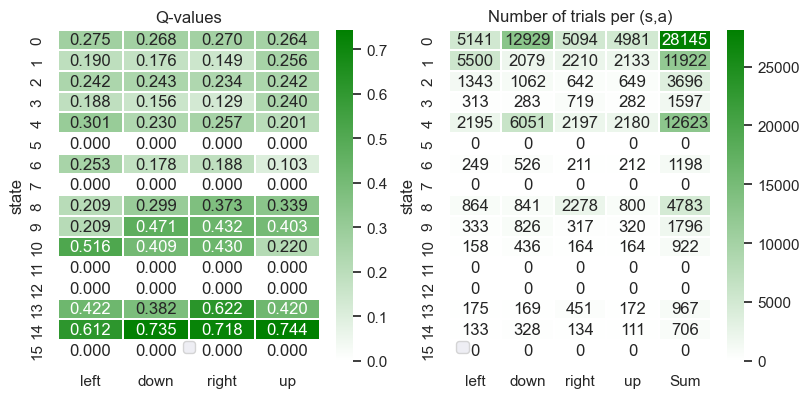

In [95]:
fig, ax = uks_mpl.subplots(2, 1, width_per=4, height_per=4)

uks_mpl.heatmap_df(Q_df, ax=ax[0], annot=True, fmt=".3f")
ax[0].set_title("Q-values")
uks_mpl.heatmap_df(n_df, ax=ax[1], annot=True)
ax[1].set_title("Number of trials per (s,a)")
fig

In [96]:
%%wandb
## DO NOT CHANGE THIS CELL. CHANGING ANY PART OF THIS CELL CAN DISQUALIFY THE SUBMISSION
#Evaluation of trained policy
init()
num_episodes=1000; #number of episodes for evaluation
episode_max_length=100
movingAverageArray=[]
score=0
env.reset()
for i in range(num_episodes):
    reset_state = env.reset()
    s = reset_state[0]
    d = False #not done
    for t in range(episode_max_length):
        a = np.argmax(Q[s,:])
        s, r, d, _, _ = env.step(a)
        if d == True:
            break
    #log per-episode reward and moving average over 100 episodes
    wandb.log({ "evaluation reward" : rEpisode, "evaluation reward moving average" : movingAverage, "evaluation episode" : i})
    movingAverageArray.append(movingAverage)
    #score is x if there is a window of 100 consecutive episodes where moving average was at least x
    if i>100:
        score=max(score,min(movingAverageArray[i-100:i-1]))


wandb.run.summary["score"]=score

In [97]:
score

np.float64(0.24242424242424243)

In [98]:
run.finish()

evaluation episode,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇████
evaluation reward,█▁███▁▁█▁▁█▁█▁▁▁█▁▁▁▁▁▁▁█▁█▁▁██▁▁▁▁▁▁█▁█
evaluation reward moving average,▁▁█▇▆▆▄▃▄▄█▇▆▆▇▆▆▄▇▅▇▆▅▆▆▅▅▅▃▄▅▇▇█▇▅▅▇█▇
training episode,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
training reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁
training reward moving average,▆▅▃█▃▁▁▆▃▃▃▃▃▃▁▁▃▃▁▁▁▃▁▆▃▁▁▃▃▁▃▁▆▅▃▁▃▁▁▅
evaluation episode,999
evaluation reward,0
evaluation reward moving average,0.28283
number of training episodes,10000
score,0.24242
